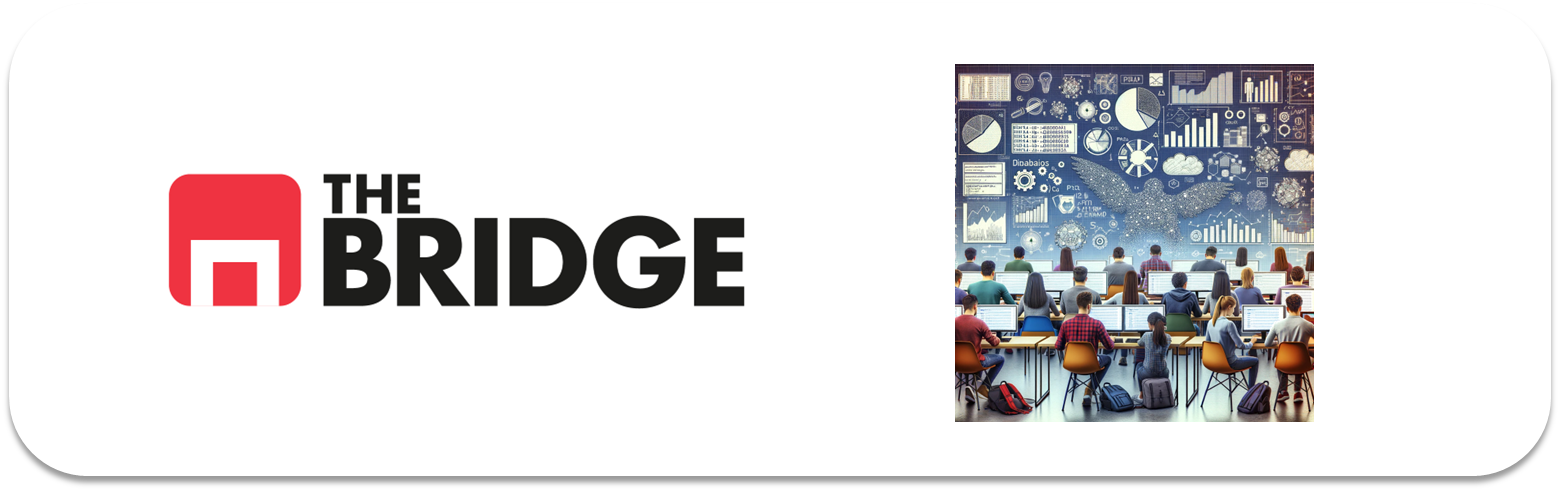

## PRACTICA OBLIGATORIA: **Clasificacion y Regresion Logistica**

* La práctica obligatoria de esta unidad consiste en modelar la supervivencia en el Titanic, por fin, además de una parte adicional multiclase. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [329]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split 
from bootcampviztools import plot_categorical_relationship_fin, pinta_distribucion_categoricas, plot_categorical_numerical_relationship, plot_combined_graphs, \
    plot_grouped_boxplots, plot_grouped_histograms, grafico_dispersion_con_correlacion, bubble_plot

### Indicaciones

A continuación tienes las indicaciones para hacer el modelado. No necesariamente tienes que seguirlos al pie de la letra, porque a partir de ahora ya las práctica obligatorias dejarán de ser mayormente guiadas por ejercicios y serán más de libre desarrollo, aunque con objetivos específicos, claros y determinados. 

En concreto se pide hacer un modelo de regresión logística, evaluarlo contra un dataset de test reservado del original mostrando las métricas propias de los problemas de clasificación, la matriz de confusión y la curva ROC. Además se pide comparar las predicciones con los valores reales y al final adaptar el modelo a un problema multiclase.

Los pasos para guiar el trabajo:
1. Carga el dataset del Titanic. 
2. Deshazte de las variables que no vayas a usar. Limpia lo que creas necesarios pero no hagas imputaciones.
3. Escoge y analiza la variable target de forma gráfica y razona sobre el impacto de la distribución en los resultados esperados. Ten en cuenta que lo que queremos es poder predecir si un pasajero sobrevivirá.
4. Haz el split en train y test que creas conveniente pero asegurándote que ambos conjuntos tienen un reparto similar de pasajeros embarcados en las tres ciudades.
5. Construye las parejas X,y de train y test.
6. Ahora sí imputa los nulos con medias y modas en la X de train. Guarda esas medias que necesitarás en la parte de test.
7. Haz un mini-EDA, selecciona las features que quieres quedarte y por qué.
8. Trata las variables para que funcionen lo mejor posible en el modelo.
9. Construye un modelo de regresión logística.
10. EXTRA: Analiza si lo crees conveniente los pesos y la importancia de las features.
11. Procesa el dataset de Test para que puedas usarlo en la evaluación 
12. Evalúa tu modelo contra el dataset de test y train. Obten las matrices de confusión y las métricas que creas adecuadas. Haz un pequeño assesment de su generabilidad.
13. EXTRA: Halla la probabilidad de supervivencia de un hombre de entre 30 y 40 años, que embarcó en Southampton en segunda clase, viajaba solo y no pagó el billete. PISTA: En este caso tendrás que calcular varias probabilidades y hacer la media de ellas.
14. EXTRA: Aprovecha todo el trabajo haciendo un único cambio en el target, ahora será la clase del viajero. Cambia el target quitándolo de X_train, X_test y añade a estos el target anterior. El resto no deberías cambiarlo. Entrena y evalua el modelo sólo con el classification_report.  



In [330]:
df_titanic = pd.read_csv("./data/titanic.csv")
df_titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


**LIMPIEZA DE VARIABLES**

Hay variables categóricas duplicadas con info redundante. Nos quedaremos con aquellas que ya están representadas de forma numérica (por ejemplo, priorizaremos *pclass* frente a *class*), pues se ajustan mejor a la construcción de nuestro modelo. 

In [331]:
# nos deshacemos de las siguientes variables
not_used = ["sex","embarked","class","adult_male","deck","alive"]

df_titanic.drop(columns= not_used, inplace=True)

In [332]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   age          714 non-null    float64
 3   sibsp        891 non-null    int64  
 4   parch        891 non-null    int64  
 5   fare         891 non-null    float64
 6   who          891 non-null    object 
 7   embark_town  889 non-null    object 
 8   alone        891 non-null    bool   
dtypes: bool(1), float64(2), int64(4), object(2)
memory usage: 56.7+ KB


In [333]:
# fusionamos 'sibsp' y 'parch' en una sola variable 'family_members', ya hemos comprobado en info() que ninguna contiene nulos

df_titanic["family_members"] = df_titanic.sibsp + df_titanic.parch
df_titanic.drop(columns=["sibsp","parch"], inplace=True) # ya las podemos desechar para simplificar 

In [334]:
# por último trataremos 'who' y 'embark_town' para pasarlas a numéricas discretas

# 'WHO' --> así queda la clasificacón: 0 man / 1 woman / 2 child

df_titanic.replace("man","0", inplace=True)
df_titanic.replace("woman","1", inplace=True)
df_titanic.replace("child","2", inplace=True)

# replace es un método de los string, pasamos los números a int
df_titanic["who"] = df_titanic.who.astype(int)


In [335]:
# EMBARK_TOWN --> 0 Southampton / 1 Cherbourg / 2 Queenstown

df_titanic.replace("Southampton", "0",inplace=True)
df_titanic.replace("Cherbourg", "1",inplace=True)
df_titanic.replace("Queenstown", "2",inplace=True)

# nos guardamos la siguiente sintaxis para convertirlo a int después de las imputaciones, pues esta columna contiene valores nulos
# df_titanic["embark_town"] = df_titanic.embark_town.astype(int)

In [336]:
# ésta es la pinta que tiene nuestro dataset tras el tratamiento de variables. Toda categórica ha sido convertida o sustituida por su equivalente 
# binario o num discreta (alone se queda como booleana pues el programa lo entiende como binaria)

df_titanic

,survived,pclass,age,fare,who,embark_town,alone,family_members
0,0,3,22.0,7.2500,0,0,False,1
1,1,1,38.0,71.2833,1,1,False,1
2,1,3,26.0,7.9250,1,0,True,0
3,1,1,35.0,53.1000,1,0,False,1
4,0,3,35.0,8.0500,0,0,True,0
...,...,...,...,...,...,...,...,...
886,0,2,27.0,13.0000,0,0,True,0
887,1,1,19.0,30.0000,1,0,True,0
888,0,3,NaN,23.4500,1,0,False,3
889,1,1,26.0,30.0000,0,1,True,0


**TARGET**

Nuestra variable target será *survived*, por lo que nos encontramos ante un modelo de regresión logística binaria que predecirá si un pasajero sobrevivirá o no.

Vemos que, aunque su distribución no está del todo desbalanceada, claramente destacan los pasajeros que NO sobrevivieron. Esto podría impactar de forma negativa a la hora de entrenar nuestro modelo según clasificador que escojamos (en concreto con 'accuracy', pues no le sientan bien los datos poco balanceados; las predicciones se ajustarán a las proporciones de survived en lugar de diferenciar bien las clases). 
Veremos otras métricas como la matriz de confusión o a curva ROC.

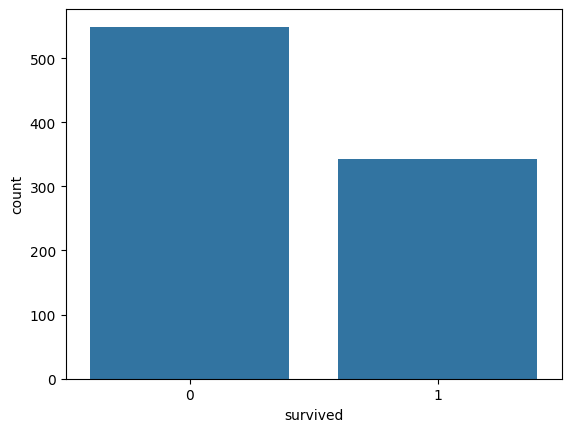

In [337]:
target = df_titanic.survived

sns.countplot(data=df_titanic, x=target);

**SPLIT DATASET TRAIN/TEST**

Se nos pide que los datos tengan un reparto similar entre las 3 ciudades en las que embarcaron los pasajeros.

In [338]:
# vemos la distribución de las ciudades

df_titanic.embark_town.value_counts(normalize=True)

embark_town
0    0.724409
1    0.188976
2    0.086614
Name: proportion, dtype: float64

In [339]:
# hacemos el reparto de manera aleatoria 

X = df_titanic.drop(columns="survived", axis=1)
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=25) 

In [340]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(712, 7)
(712,)
(179, 7)
(179,)


In [341]:
# tras varios intentos (cambiando el valor de la semilla), damos con un resultado bastante similar en cuanto a distribución del puerto de embarque
X_train.embark_town.value_counts(normalize=True)

embark_town
0    0.728551
1    0.187060
2    0.084388
Name: proportion, dtype: float64

In [342]:
X_test.embark_town.value_counts(normalize=True)

embark_town
0    0.707865
1    0.196629
2    0.095506
Name: proportion, dtype: float64

**TRATAMIENTO DE LOS NaN** en X_train

A tener en cuenta posteriormente en nuestro X-test, donde tendremos que aplicar el mismo tratamiento: 

- imputar moda valores nulos de 'embark_town' y convertir la variable a int (pending del apartado tratamiento de variables)
- imputar media de edad en 'age' (distinguiendo por condición de mujer/hombre/niño para evitar la desviación sobre todo en el grupo de los niños)

In [343]:
X_train.info() # tenemos valores nulos en 'age' y en 'embark_town'

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 410 to 132
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pclass          712 non-null    int64  
 1   age             572 non-null    float64
 2   fare            712 non-null    float64
 3   who             712 non-null    int64  
 4   embark_town     711 non-null    object 
 5   alone           712 non-null    bool   
 6   family_members  712 non-null    int64  
dtypes: bool(1), float64(2), int64(3), object(1)
memory usage: 39.6+ KB


In [344]:
# VARIABLE embark_town

X_train.embark_town.mode()  # buscamos la moda --> 0 Southampton

0    0
Name: embark_town, dtype: object

In [345]:
# la imputamos
X_train.loc[X_train.embark_town.isna(), "embark_town"] = "0"

# y ahora sí, podemos convertir esta columna a int (lo teniamos pending del apartado 'tratamiento de variables')
X_train["embark_town"] = X_train.embark_town.astype(int)

In [346]:
# VARIABLE 'age'

# imputaremos la media de edad
# pero primero distinguiremos entre mujeres, hombres y niños para ser lo más rigurosos posible y evitar la desviación en el grupo de los niños

# máscaras booleanas para cada grupo
son_hombres = X_train.who == 0
son_mujeres = X_train.who == 1
son_ninos = X_train.who == 2

# sacamos la media de edad de cada grupo
media_mujer = X_train.loc[son_mujeres, "age"].mean()
media_hombre = X_train.loc[son_hombres,"age"].mean()
media_nino = X_train.loc[son_ninos, "age"].mean()


# máscara que contiene los nulos
sin_edad = X_train.age.isna()

# agrupación por condición hombre/mujer/niño + valores nulos --> imputamos la media correspondiente
X_train.loc[son_mujeres & sin_edad, "age"] = media_mujer
X_train.loc[son_hombres & sin_edad, "age"] = media_hombre
X_train.loc[son_ninos & sin_edad, "age"] = media_nino

X_train.age.isna().value_counts() # no queda ningún valor nulo

age
False    712
Name: count, dtype: int64

In [347]:
# echamos otro vistazo general, todo perfecto
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 410 to 132
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pclass          712 non-null    int64  
 1   age             712 non-null    float64
 2   fare            712 non-null    float64
 3   who             712 non-null    int64  
 4   embark_town     712 non-null    int64  
 5   alone           712 non-null    bool   
 6   family_members  712 non-null    int64  
dtypes: bool(1), float64(2), int64(4)
memory usage: 39.6 KB


**MINI-EDA**

Nos cargaremos las variables que no estén muy relacionadas con el target.

In [348]:
# separamos las variables categóricas de las numéricas:

# Cuidado, nuestra target es una variable categórica, por eso estamos ante un problema de clasificación

categoricas = ["pclass","who","embark_town","alone"]
numericas = ["age","fare"] # family members también, pero posteriormente la hemos eliminado

In [349]:
df_eda = X_train.copy()  
df_eda["survived"] = y_train.copy() # añadimos la variable survived a la partición de train para poder estudiarla junto con el resto de variables

df_eda

,pclass,age,fare,who,embark_town,alone,family_members,survived
410,3,32.963077,7.8958,0,0,True,0,0
638,3,41.000000,39.6875,1,0,False,5,0
395,3,22.000000,7.7958,0,0,True,0,0
221,2,27.000000,13.0000,0,0,True,0,0
800,2,34.000000,13.0000,0,0,True,0,0
...,...,...,...,...,...,...,...,...
317,2,54.000000,14.0000,0,0,True,0,0
143,3,19.000000,6.7500,0,2,True,0,0
474,3,22.000000,9.8375,1,0,True,0,0
318,1,31.000000,164.8667,1,0,False,2,1


In [350]:
#X_train.drop(columns="family_members", inplace=True)

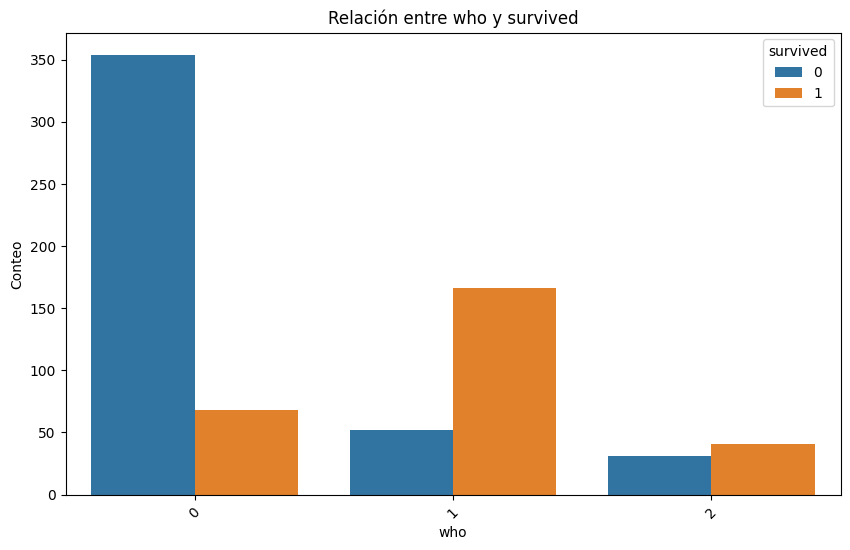

In [351]:
# bivariante 'survived' & 'who'  (mayor correlación)

# destaca significativamente que gran parte de los hombres murieron frente al caso de las mujeres y los niños, donde por lo general, tuvieron mayor
# probabilidad de supervivencia.
 
plot_categorical_relationship_fin(df_eda,"who","survived")

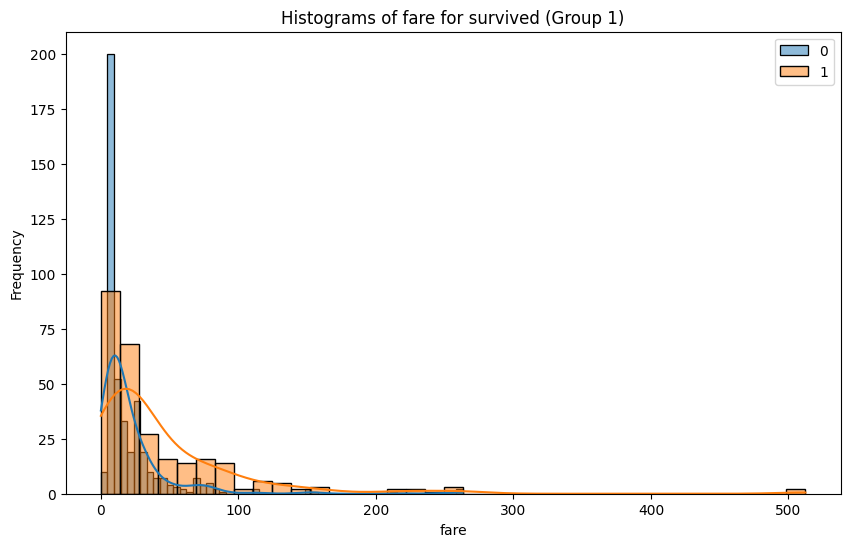

In [352]:
# bivariante 'survived' y 'fare' 

# cuanto más caro fue el pasaje, mayor es el índice de supervivencia

plot_grouped_histograms(df_eda, "survived","fare", group_size= 2)

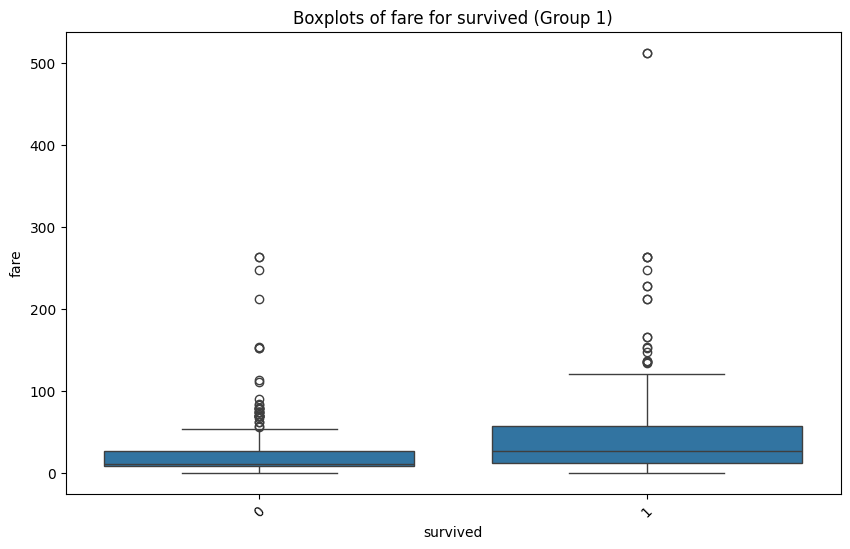

In [353]:
plot_grouped_boxplots(df_eda,"survived","fare")

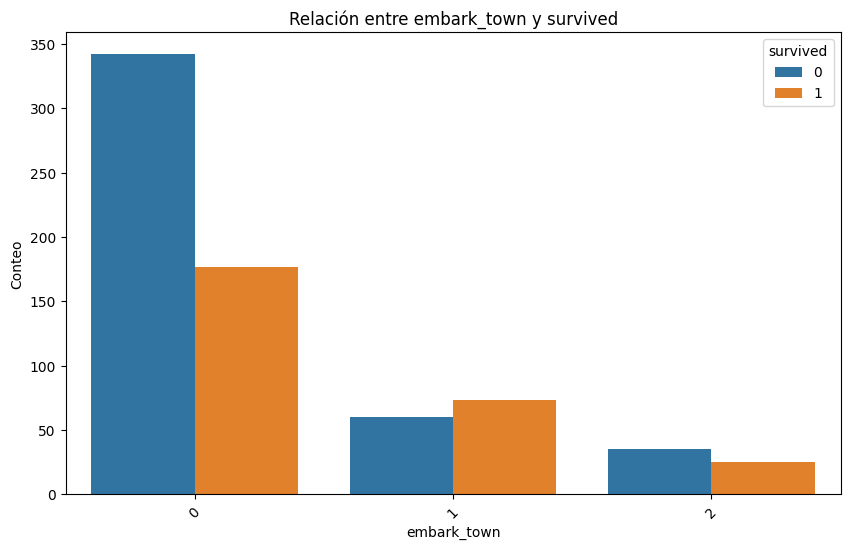

In [354]:
# Destaca considerablemente la proporción de fallecidos entre los que embarcaron en Southampton, frente a las otras dos ciudades.

plot_categorical_relationship_fin(df_eda,"embark_town", "survived")

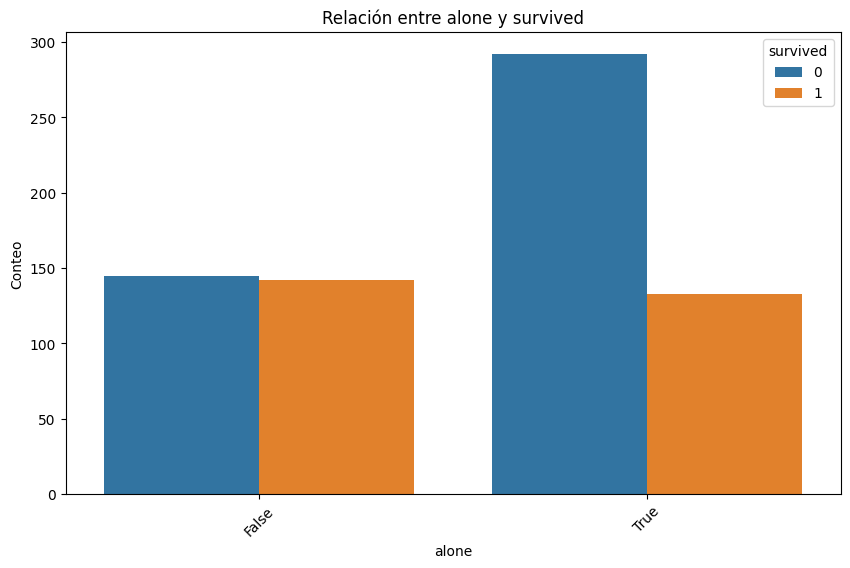

In [355]:
# bivariante 'survived' & 'alone'

# la distribución está bastante balanceada excepto entre los pasajeros que viajaban solos, donde destacan los fallecidos
plot_categorical_relationship_fin(df_eda,"alone", "survived")

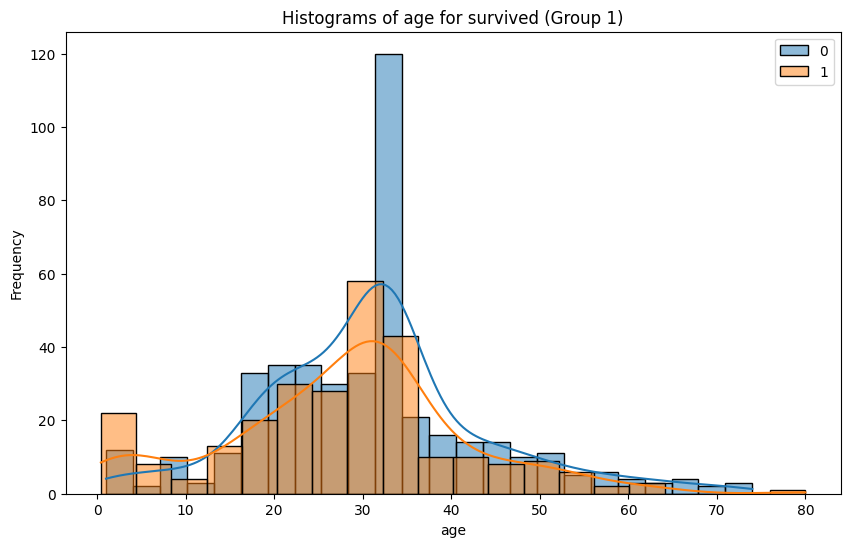

In [356]:
# bivariante 'survived' & 'age'
# la distribución está bastante balanceada en todos los rangos de edad, aunque sí que destaca un pico de fallecidos alrededor de los 35 años.
plot_grouped_histograms(df_eda, "survived","age",group_size= 2)

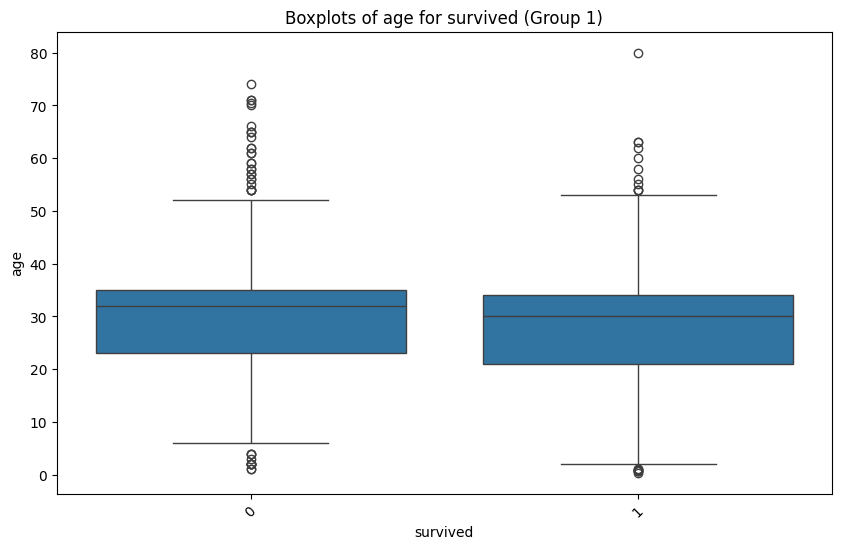

In [357]:
plot_grouped_boxplots(df_eda,"survived","age")

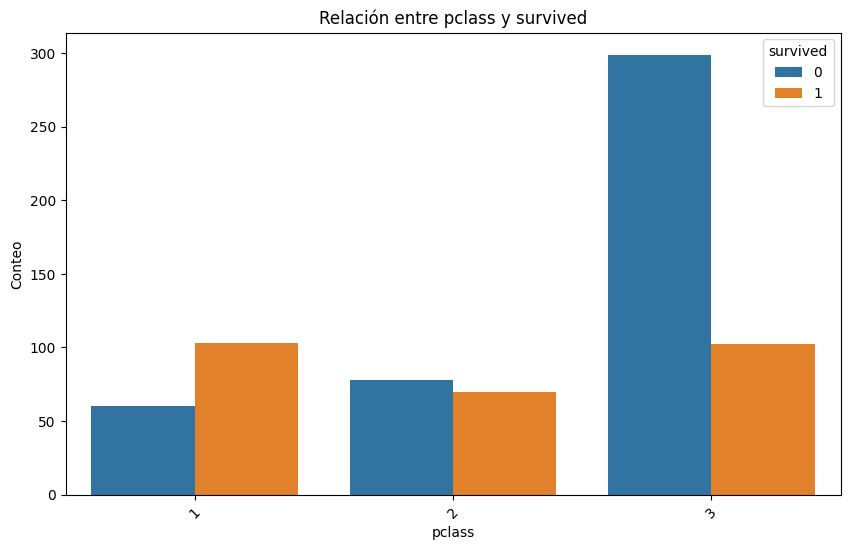

In [358]:
# bivariante 'survived' y 'pclass'

# es interesante ver como en primera clase los supervivientes superan a las fallecidos; en segunda esta más o menos distribuido con los fallecidos
# en cabeza; y sobre todo, en tercera clase, destacan enormemente los fallecidos frente  a los supervivientes.

plot_categorical_relationship_fin(df_eda,"pclass", "survived")

Tras el análisis bivariante, decidimos quedarnos con todas las variables analizadas. Aunque algunas tengan poca correlación, aportan datos muy interesantes que, combinados con otros factores, pueden ser determinantes en la probabilidad de supervivencia. Consideramos que van a ser fundamentales en el entrenamiento de nuestro modelo.

**PREPARACIÓN DE LAS FEATURES**

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'fare'}>]], dtype=object)

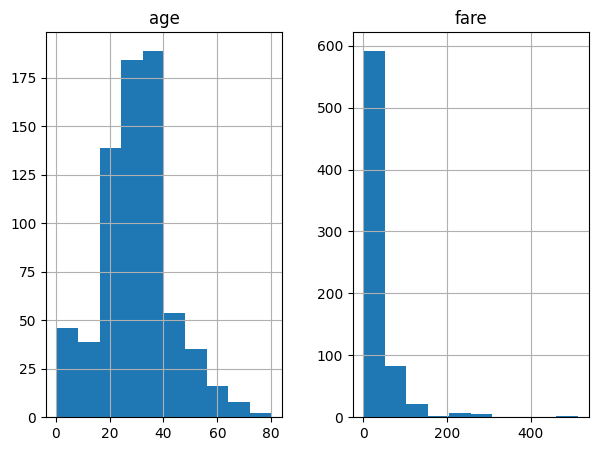

In [359]:
# pintamos los histogramas de las variables numéricas antes de aplicar el logaritmo. 
# 'age' está mejor distribuída, pero 'fare' tiene una larga cola y eso no le sienta bien al modelo.

X_train[numericas].hist(figsize=(7,5))

In [360]:
X_train.describe().T   

,count,mean,std,min,25%,50%,75%,max
pclass,712.0,2.334270,0.825443,1.00,2.0000,3.000000,3.0000,3.0000
age,712.0,29.903246,13.067550,0.42,22.0000,31.742857,35.0000,80.0000
fare,712.0,30.842128,47.270804,0.00,7.8958,14.254150,30.0708,512.3292
who,712.0,0.508427,0.672913,0.00,0.0000,0.000000,1.0000,2.0000
embark_town,712.0,0.355337,0.631008,0.00,0.0000,0.000000,1.0000,2.0000
family_members,712.0,0.941011,1.660970,0.00,0.0000,0.000000,1.0000,10.0000


In [363]:
# Ahora sí, aplicamos el logaritmo a 'fare'. También se lo aplicaremos al X_test

X_train['fare'] = X_train['fare'].apply(np.log)

<Axes: >

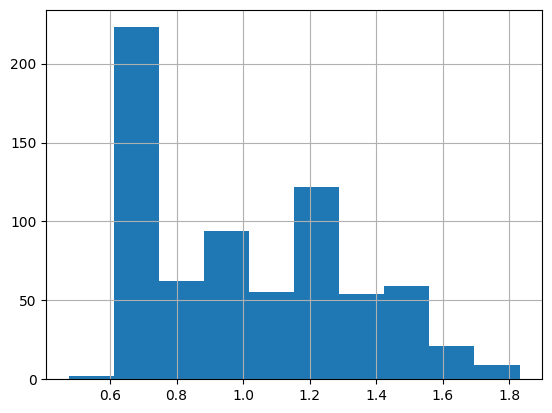

In [364]:
# ahora vemos la pinta qué tiene su histograma

X_train.fare.hist()

# esta distribución sentará mucho mejor al modelo que la original con la larga cola

In [ ]:
X_train.info() # ahora tengo valores nulos en 'fare' después de aplicarle el logaritmo...

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 410 to 132
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pclass          712 non-null    int64  
 1   age             712 non-null    float64
 2   fare            701 non-null    float64
 3   who             712 non-null    int64  
 4   embark_town     712 non-null    int64  
 5   alone           712 non-null    bool   
 6   family_members  712 non-null    int64  
dtypes: bool(1), float64(2), int64(4)
memory usage: 39.6 KB


In [ ]:
# los imputo por la media

media = X_train.fare.mean()

X_train.loc[X_train.fare.isna(), "fare"] = media

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 410 to 132
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pclass          712 non-null    int64  
 1   age             712 non-null    float64
 2   fare            712 non-null    float64
 3   who             712 non-null    int64  
 4   embark_town     712 non-null    int64  
 5   alone           712 non-null    bool   
 6   family_members  712 non-null    int64  
dtypes: bool(1), float64(2), int64(4)
memory usage: 39.6 KB


**CONSTRUCCIÓN DEL MODELO DE REGRESIÓN LOGÍSTICA**

In [371]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter = 100) # escogemos 100 iteraciones pues solo contamos con unas 800 instancias

log_reg.fit(X_train, y_train)

LogisticRegression()

In [372]:
print(log_reg.coef_) # coeficientes para cada feature
print(log_reg.intercept_) # intercept, o cuál sería el resultado si el valor de todas mis features fuese 0
print(log_reg.classes_) # cuántas clases tenemos: 0 not survived / 1 survived

[[-0.72482785 -0.00350928  0.81763862  2.20936213  0.20039999 -0.75790663
  -0.7493325 ]]
[0.28042723]
[0 1]


**PROCESAMIENTO DE x_TEST**

Aplicamos las mismas transformaciones que en X_train.

In [ ]:
X_test.info() # sin mirar demasiado, tenemos valores nulos en las mismas variables que nuestro X_train

<class 'pandas.core.frame.DataFrame'>
Index: 179 entries, 760 to 373
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pclass          179 non-null    int64  
 1   age             142 non-null    float64
 2   fare            179 non-null    float64
 3   who             179 non-null    int64  
 4   embark_town     178 non-null    object 
 5   alone           179 non-null    bool   
 6   family_members  179 non-null    int64  
dtypes: bool(1), float64(2), int64(3), object(1)
memory usage: 10.0+ KB


In [ ]:
# VARIABLE embark_town

# imputamos la moda
X_test.embark_town.mode() # ---> 0 Southampton

X_test.loc[X_test.embark_town.isna(), "embark_town"] = "0"

# y convertimos esta columna a int 
X_test["embark_town"] = X_test.embark_town.astype(int)

In [ ]:
# VARIABLE 'age'

# máscaras booleanas para cada grupo
son_hombres = X_test.who == 0
son_mujeres = X_test.who == 1
son_ninos = X_test.who == 2

# sacamos la media de edad de cada grupo
media_mujer = X_test.loc[son_mujeres, "age"].mean()
media_hombre = X_test.loc[son_hombres,"age"].mean()
media_nino = X_test.loc[son_ninos, "age"].mean()


# máscara que contiene los nulos
sin_edad = X_test.age.isna()

# agrupación por condición hombre/mujer/niño + valores nulos --> imputamos la media correspondiente
X_test.loc[son_mujeres & sin_edad, "age"] = media_mujer
X_test.loc[son_hombres & sin_edad, "age"] = media_hombre
X_test.loc[son_ninos & sin_edad, "age"] = media_nino

X_test.age.isna().value_counts() # no queda ningún valor nulo

age
False    179
Name: count, dtype: int64

In [ ]:
X_test.info() # no queda ningún nulo

<class 'pandas.core.frame.DataFrame'>
Index: 179 entries, 760 to 373
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pclass          179 non-null    int64  
 1   age             179 non-null    float64
 2   fare            179 non-null    float64
 3   who             179 non-null    int64  
 4   embark_town     179 non-null    int64  
 5   alone           179 non-null    bool   
 6   family_members  179 non-null    int64  
dtypes: bool(1), float64(2), int64(4)
memory usage: 10.0 KB


In [ ]:
# por último, desechamos la variable 'family_members'

X_test.drop(columns="family_members", inplace=True)

10. EXTRA: Analiza si lo crees conveniente los pesos y la importancia de las features.

12. Evalúa tu modelo contra el dataset de test y train. Obten las matrices de confusión y las métricas que creas adecuadas. Haz un pequeño assesment de su generabilidad.
13. EXTRA: Halla la probabilidad de supervivencia de un hombre de entre 30 y 40 años, que embarcó en Southampton en segunda clase, viajaba solo y no pagó el billete. PISTA: En este caso tendrás que calcular varias probabilidades y hacer la media de ellas.
14. EXTRA: Aprovecha todo el trabajo haciendo un único cambio en el target, ahora será la clase del viajero. Cambia el target quitándolo de X_train, X_test y añade a estos el target anterior. El resto no deberías cambiarlo. Entrena y evalua el modelo sólo con el classification_report.  

En concreto se pide hacer un modelo de regresión logística, evaluarlo contra un dataset de test reservado del original mostrando las métricas propias de los problemas de clasificación, la matriz de confusión y la curva ROC. Además se pide comparar las predicciones con los valores reales y al final adaptar el modelo a un problema multiclase.